____
### Mounting Google Drive and Importing Dependencies
___
We mount Google Drive to access datasets and save results. Required libraries for data processing, modeling, and evaluation are also imported. A random seed is set for reproducibility, and warnings are suppressed for cleaner output.
____

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import shap

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV,
    GridSearchCV
)
import xgboost as xgb
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    matthews_corrcoef,
    brier_score_loss,
    roc_curve,
    auc
)

# Data Preprocessing & Utilities
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.calibration import calibration_curve
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
import os

# Dimensionality Reduction
from sklearn.decomposition import PCA
import umap.umap_ as umap

# Random Seed
np.random.seed(42)


In [3]:
import xgboost as xgb
from xgboost import XGBClassifier

In [4]:
import os

print(os.listdir('/content/drive/MyDrive'))

['Colab Notebooks', 'GSE300475_RAW.tar', 'MultimodalCSVs', 'flux_outputs.csv', 'flux_outputs.h5ad', 'flux_batches', 'GSE300475_extracted', 'tri_modality_tcr.csv', 'transcriptomics.csv', 'fluxomics.csv']


____
Loading and Inspecting Gene Expression Data
We load the single-cell gene expression dataset from a CSV file stored in Google Drive. This dataset includes normalized gene expression values for 58,177 cells across 2,000+ genes, alongside metadata columns such as `response` (responder vs non-responder) and `sample_id`.
Basic dataset characteristics are printed to verify dimensions and preview the first few rows, ensuring the data was loaded correctly with expected columns.
____

In [5]:
gene_df = pd.read_csv('/content/drive/MyDrive/transcriptomics.csv', index_col=0)

In [6]:
# Basic shape and structure
print("Shape of gene_df:", gene_df.shape)
print("\nFirst 5 rows:")
print(gene_df.head())

print("\nColumn names (first 10):")
print(gene_df.columns[:10])

Shape of gene_df: (58177, 2002)

First 5 rows:
                     response      sample_id  ENSG00000272512  \
AAACCTGAGAAGGGTA-1  Responder  GSM9061665_S1        -0.013603   
AAACCTGAGACTGTAA-1  Responder  GSM9061665_S1        -0.013603   
AAACCTGAGCAGCGTA-1  Responder  GSM9061665_S1        -0.013603   
AAACCTGAGCCAACAG-1  Responder  GSM9061665_S1        -0.013603   
AAACCTGAGCGTGAAC-1  Responder  GSM9061665_S1        -0.013603   

                    ENSG00000230415  ENSG00000169885  ENSG00000142609  \
AAACCTGAGAAGGGTA-1        -0.010721        -0.010086        -0.008178   
AAACCTGAGACTGTAA-1        -0.010721        -0.010086        -0.008178   
AAACCTGAGCAGCGTA-1        -0.010721        -0.010086        -0.008178   
AAACCTGAGCCAACAG-1        -0.010721        -0.010086        -0.008178   
AAACCTGAGCGTGAAC-1        -0.010721        -0.010086        -0.008178   

                    ENSG00000187730  ENSG00000287727  ENSG00000287384  \
AAACCTGAGAAGGGTA-1         -0.01729        -0.0238

____
Convert categorical response labels into binary format for modeling: 1 = Responder, 0 = Non-responder, and display class counts.
____

In [7]:
gene_df.head()

,response,sample_id,ENSG00000272512,ENSG00000230415,ENSG00000169885,ENSG00000142609,ENSG00000187730,ENSG00000287727,ENSG00000287384,ENSG00000162458,...,ENSG00000198712,ENSG00000228253,ENSG00000198899,ENSG00000198840,ENSG00000212907,ENSG00000198786,ENSG00000198727,ENSG00000276256,ENSG00000277856,ENSG00000275063
AAACCTGAGAAGGGTA-1,Responder,GSM9061665_S1,-0.013603,-0.010721,-0.010086,-0.008178,-0.01729,-0.023815,-0.00749,-0.005667,...,1.765706,2.438390,2.329344,2.054127,2.181029,2.719458,1.961893,-0.027983,-0.015876,-0.02753
AAACCTGAGACTGTAA-1,Responder,GSM9061665_S1,-0.013603,-0.010721,-0.010086,-0.008178,-0.01729,-0.023815,-0.00749,-0.005667,...,-0.216031,0.300590,-0.860992,-0.160776,-0.052397,-0.184155,0.048195,-0.027983,-0.015876,-0.02753
AAACCTGAGCAGCGTA-1,Responder,GSM9061665_S1,-0.013603,-0.010721,-0.010086,-0.008178,-0.01729,-0.023815,-0.00749,-0.005667,...,0.931615,0.417104,-0.129276,0.759760,-1.443564,0.277220,0.157571,-0.027983,-0.015876,-0.02753
AAACCTGAGCCAACAG-1,Responder,GSM9061665_S1,-0.013603,-0.010721,-0.010086,-0.008178,-0.01729,-0.023815,-0.00749,-0.005667,...,0.324596,0.623172,0.399440,0.875306,0.765933,0.503159,0.436196,-0.027983,-0.015876,-0.02753
AAACCTGAGCGTGAAC-1,Responder,GSM9061665_S1,-0.013603,-0.010721,-0.010086,-0.008178,-0.01729,-0.023815,-0.00749,-0.005667,...,-0.194472,0.643405,0.206952,0.203505,0.814024,0.129373,0.151363,-0.027983,-0.015876,-0.02753


In [34]:
gene_df.info(verbose=True, show_counts=True) # Show the first 20

<class 'pandas.core.frame.DataFrame'>
Index: 58177 entries, AAACCTGAGAAGGGTA-1 to TTTGTCATCTGTTTGT-1
Data columns (total 2003 columns):
 #     Column           Non-Null Count  Dtype  
---    ------           --------------  -----  
 0     response         58177 non-null  object 
 1     sample_id        58177 non-null  object 
 2     ENSG00000272512  58177 non-null  float64
 3     ENSG00000230415  58177 non-null  float64
 4     ENSG00000169885  58177 non-null  float64
 5     ENSG00000142609  58177 non-null  float64
 6     ENSG00000187730  58177 non-null  float64
 7     ENSG00000287727  58177 non-null  float64
 8     ENSG00000287384  58177 non-null  float64
 9     ENSG00000162458  58177 non-null  float64
 10    ENSG00000236936  58177 non-null  float64
 11    ENSG00000173372  58177 non-null  float64
 12    ENSG00000159189  58177 non-null  float64
 13    ENSG00000173369  58177 non-null  float64
 14    ENSG00000261326  58177 non-null  float64
 15    ENSG00000271420  58177 non-null  float64


In [9]:
duplicate_count = gene_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


In [10]:
# Missing values per column in gene_df
missing_per_column = gene_df.isnull().sum()
print("\nMissing values per column:")
print(missing_per_column[missing_per_column > 0])


Missing values per column:
Series([], dtype: int64)


In [11]:
gene_df['response_binary'] = gene_df['response'].map({'Responder': 1, 'Non-responder': 0})
print(gene_df['response_binary'].value_counts())

response_binary
0    38976
1    19201
Name: count, dtype: int64


____
Summarize the gene expression DataFrame by showing the number of non-null values and data types for each column.
____

In [12]:
non_null_counts = gene_df.notna().sum()
dtypes = gene_df.dtypes

summary_df = pd.DataFrame({
    'Non-Null Count': non_null_counts,
    'Data Type': dtypes
}).sort_index()

print(summary_df)

                 Non-Null Count Data Type
ENSG00000003436           58177   float64
ENSG00000004776           58177   float64
ENSG00000004939           58177   float64
ENSG00000005249           58177   float64
ENSG00000005381           58177   float64
...                         ...       ...
ENSG00000288162           58177   float64
ENSG00000288235           58177   float64
response                  58177    object
response_binary           58177     int64
sample_id                 58177    object

[2003 rows x 2 columns]


In [13]:
# View missing values in gene_df
missing_counts = gene_df.isna().sum()
missing_percent = (missing_counts / len(gene_df)) * 100

missing_df = pd.DataFrame({
    'Missing_Count': missing_counts,
    'Missing_Percent': missing_percent.round(2)
}).sort_values(by='Missing_Count', ascending=False)

if missing_counts.sum() == 0:
    print(" No missing values found in gene_df.")
else:
    print("⚠ Missing values detected in gene_df.")

print("\nTop 20 columns by missing values:")
print(missing_df.head(20))

 No missing values found in gene_df.

Top 20 columns by missing values:
                 Missing_Count  Missing_Percent
response_binary              0              0.0
response                     0              0.0
sample_id                    0              0.0
ENSG00000184343              0              0.0
ENSG00000198753              0              0.0
ENSG00000183837              0              0.0
ENSG00000147394              0              0.0
ENSG00000102287              0              0.0
ENSG00000236337              0              0.0
ENSG00000189326              0              0.0
ENSG00000129682              0              0.0
ENSG00000232611              0              0.0
ENSG00000022267              0              0.0
ENSG00000286964              0              0.0
ENSG00000227060              0              0.0
ENSG00000225689              0              0.0
ENSG00000286163              0              0.0
ENSG00000101883              0              0.0
ENSG00000101856 

____
Prepare the feature matrix (X) and label vector (y) by excluding non-feature columns such as response and sample IDs.
____

In [14]:
# Exclude columns that are not features
non_feature_cols = ['response', 'response_binary', 'sample_id']

# Select features by dropping non-feature columns
X = gene_df.drop(columns=non_feature_cols)

# Labels vector
y = gene_df['response_binary']

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Features shape: (58177, 2000)
Labels shape: (58177,)


____
Check for missing values in the feature matrix and display the total count, as well as counts per column if any exist.
____

In [15]:
nan_counts = X.isna().sum()
total_nans = nan_counts.sum()
print(f"Total missing values in features: {total_nans}")

# Optional: print columns with missing values and their counts
print(nan_counts[nan_counts > 0])

Total missing values in features: 0
Series([], dtype: int64)


____
Visualize the distribution of response classes in the dataset using a bar plot.
____

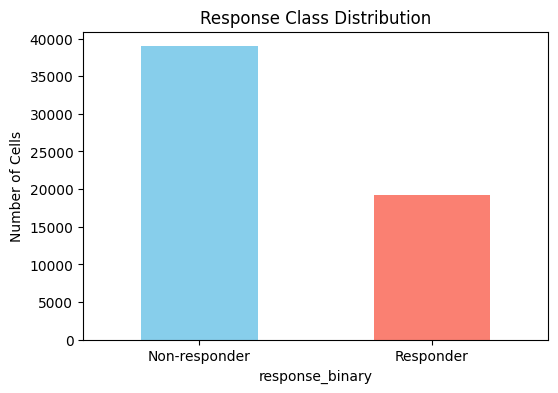

In [16]:
plt.figure(figsize=(6,4))
gene_df['response_binary'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Response Class Distribution")
plt.xticks(ticks=[0,1], labels=['Non-responder', 'Responder'], rotation=0)
plt.ylabel("Number of Cells")
plt.show()

------------------------------------------------------------
Perform Principal Component Analysis (PCA) to reduce the gene expression features to two dimensions for visualization.
Missing values are filled with zeros where present for simplicity.
A scatter plot of the first two principal components is shown, colored by response class, to explore potential separation between responders and non-responders.
____


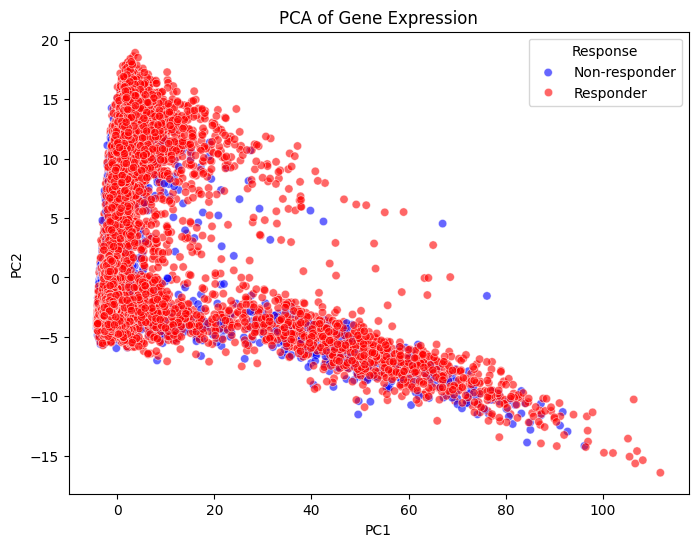

In [17]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.fillna(0))

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=gene_df['response_binary'], palette=['red', 'blue'], alpha=0.6)
plt.title("PCA of Gene Expression")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Response", labels=['Non-responder', 'Responder'])
plt.show()

------------------------------------------------------------
Perform UMAP embedding on the top 500 most variable genes to visualize single-cell gene expression patterns.
Steps include selecting top variable genes, Z-score normalization within each sample, and dimensionality reduction using UMAP.
The resulting 2D embeddings are plotted twice: first colored by response status to explore responder vs non-responder separation,
and then colored by sample ID to examine sample-specific patterns.
Finally, a table shows the number of responders and non-responders per sample.
____


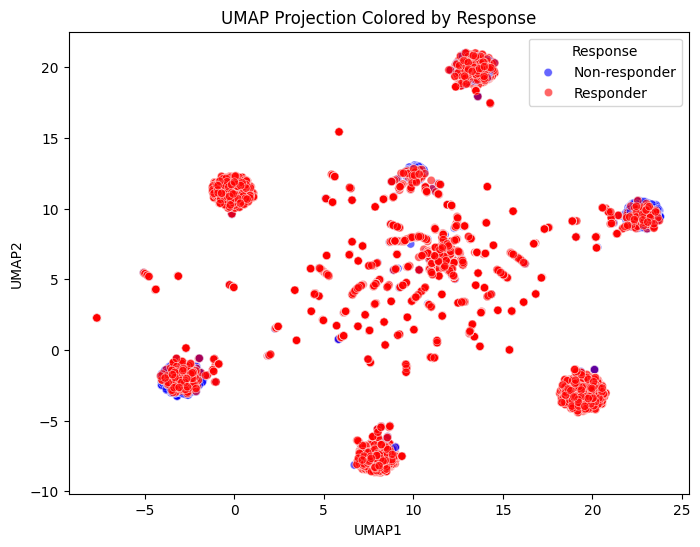

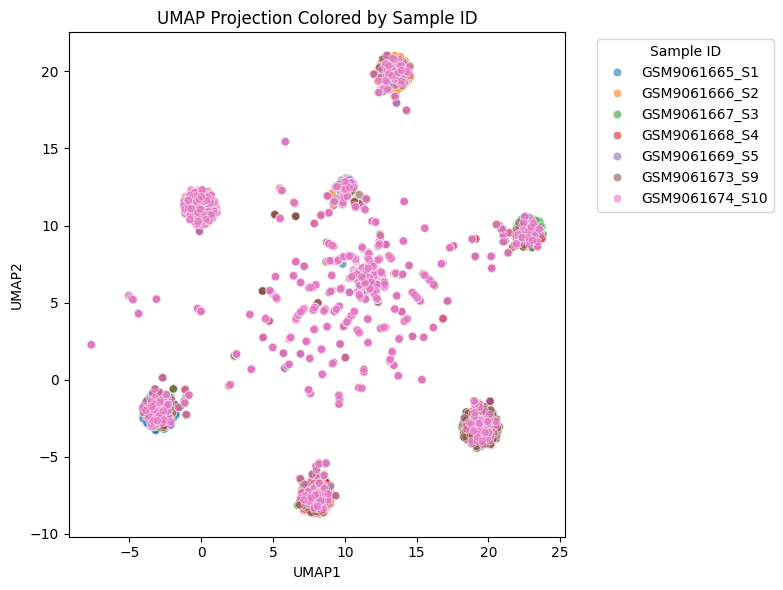

Responder count per sample:
sample_id       response     
GSM9061665_S1   Responder         8931
GSM9061666_S2   Non-responder     9069
GSM9061667_S3   Responder         7358
GSM9061668_S4   Non-responder     8723
GSM9061669_S5   Responder         2912
GSM9061673_S9   Non-responder    11480
GSM9061674_S10  Non-responder     9704
dtype: int64


In [18]:
# -----------------------------
# Step 1: Drop non-feature columns to get only genes
# -----------------------------
non_feature_cols = ['response', 'response_binary', 'sample_id']
gene_columns = [col for col in gene_df.columns if col not in non_feature_cols]

# -----------------------------
# Step 2: Select top 500 most variable genes
# -----------------------------
gene_variances = gene_df[gene_columns].var()
top500_genes = gene_variances.sort_values(ascending=False).head(500).index.tolist()

# -----------------------------
# Step 3: Z-score normalization within each sample
# -----------------------------
gene_df_scaled = gene_df.copy()
for sid in gene_df['sample_id'].unique():
    idx = gene_df['sample_id'] == sid
    scaler = StandardScaler()
    gene_df_scaled.loc[idx, top500_genes] = scaler.fit_transform(gene_df.loc[idx, top500_genes])

# -----------------------------
# Step 4: UMAP Embedding
# -----------------------------
X = gene_df_scaled[top500_genes]
y = gene_df_scaled['response_binary']
sample_labels = gene_df_scaled['sample_id']

reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X)

# -----------------------------
# Step 5: Plot 1 - Colored by Response
# -----------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1],
                hue=y, palette={0: 'red', 1: 'blue'}, alpha=0.6)
plt.title('UMAP Projection Colored by Response')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title='Response', labels=['Non-responder', 'Responder'])
plt.show()

# -----------------------------
# Step 6: Plot 2 - Colored by Sample ID
# -----------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1],
                hue=sample_labels, palette='tab10', alpha=0.6)
plt.title('UMAP Projection Colored by Sample ID')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title='Sample ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# -----------------------------
# Step 7: Count responders/non-responders per sample
# -----------------------------
print("Responder count per sample:")
print(gene_df.groupby(['sample_id', 'response']).size())

------------------------------------------------------------
Install and import the mygene package for gene annotation and querying external gene information.
This only needs to be run once.
____

In [19]:
# Install mygene package (run once)
!pip install mygene

import mygene

------------------------------------------------------------
Use the mygene package to map Ensembl gene IDs to standard gene symbols.
Steps include initializing MyGeneInfo, querying each gene ID, creating an Ensembl-to-symbol mapping,
and renaming the columns in the gene expression DataFrame (and optionally in p-value DataFrames) for easier interpretation.
____

In [20]:
# Step 1: Initialize mygene
mg = mygene.MyGeneInfo()

# Step 2: Extract all gene columns (excluding non-gene columns like 'response_binary')
gene_columns = [col for col in gene_df.columns if col != 'response_binary']

# Step 3: Query mygene for gene symbols
gene_info = mg.querymany(gene_columns, scopes='ensembl.gene', fields='symbol', species='human')

# Step 4: Build Ensembl → Symbol mapping
id_to_symbol = {}
for g in gene_info:
    ensembl_id = g['query']
    symbol = g.get('symbol')
    id_to_symbol[ensembl_id] = symbol if symbol else ensembl_id  # fallback to Ensembl if no symbol

# Step 5: Rename gene columns in gene_df
gene_df_renamed = gene_df.rename(columns=id_to_symbol)

# Step 6: Also rename gene index in pval_df
#pval_df_renamed = pval_df.rename(index=id_to_symbol)

# Now your dataframe and p-values both use gene symbols
print(gene_df_renamed.columns[:10])
#print(pval_df_renamed.head(10))

INFO:biothings.client:querying 1-1000 ...
INFO:biothings.client:querying 1001-2000 ...
INFO:biothings.client:querying 2001-2002 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


Index(['response', 'sample_id', 'ENSG00000272512', 'LINC01786', 'CALML6',
       'CFAP74', 'GABRD', 'ENSG00000287727', 'ENSG00000287384', 'FBLIM1'],
      dtype='object')


------------------------------------------------------------
Prepare the gene expression dataset with renamed gene symbols for modeling.
Steps include ensuring essential columns are present, defining features and labels,
and splitting cells into training and test sets based on patient IDs (80/20 split)
to prevent data leakage. The split maintains class balance across responders and non-responders,
and the shapes and response distributions for both sets are displayed.
____


In [21]:
from sklearn.model_selection import train_test_split

# Use renamed DataFrame with gene symbols
df = gene_df_renamed.copy()

# Ensure 'response_binary' and 'sample_id' are still present
if 'response_binary' not in df.columns:
    df['response_binary'] = gene_df['response_binary']
if 'sample_id' not in df.columns:
    df['sample_id'] = gene_df['sample_id']

# Define non-feature columns to drop
non_feature_cols = ['response', 'response_binary', 'sample_id']

# Features (genes) and labels (binary response)
X = df.drop(columns=non_feature_cols)
y = df['response_binary']

# Get unique patients from sample_id
patients = df['sample_id'].unique()

# Patient-level stratified split
train_patients, test_patients = train_test_split(
    patients,
    test_size=0.2,
    random_state=42,
    stratify=df.groupby('sample_id')['response_binary'].first()
)

# Boolean masks
train_mask = df['sample_id'].isin(train_patients)
test_mask = df['sample_id'].isin(test_patients)

# Final splits
X_train, X_test = X.loc[train_mask], X.loc[test_mask]
y_train, y_test = y.loc[train_mask], y.loc[test_mask]

# Output info
print(f"Train set shape: {X_train.shape}, {y_train.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

print("Train class distribution:")
print(y_train.value_counts(normalize=True))
print("Test class distribution:")
print(y_test.value_counts(normalize=True))

Train set shape: (43785, 2000), (43785,)
Test set shape: (14392, 2000), (14392,)
Train class distribution:
response_binary
0    0.627978
1    0.372022
Name: proportion, dtype: float64
Test class distribution:
response_binary
0    0.797665
1    0.202335
Name: proportion, dtype: float64


# **Feature Selection**

------------------------------------------------------------
Train a Random Forest to rank their importance.
The top 100 most important features are selected based on feature importances,
and both the training and test sets are filtered to include only these top features for downstream modeling.
____

In [22]:
 # 1. Keep feature names before any potential scaling
feature_names = X_train.columns

# 2. Train Random Forest on X_train
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# 3. Get top 100 feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:100]
top100_features = feature_names[indices]

# 4. Convert X_train and X_test to DataFrames if they are NumPy arrays
if not isinstance(X_train, pd.DataFrame):
    X_train = pd.DataFrame(X_train, columns=feature_names, index=y_train.index)
if not isinstance(X_test, pd.DataFrame):
    X_test = pd.DataFrame(X_test, columns=feature_names, index=y_test.index)

# 5. Keep only top 100 features
X_train = X_train[top100_features]
X_test = X_test[top100_features]

# 6. Confirm shapes
print(f"X_train shape after top 100 feature selection: {X_train.shape}")
print(f"X_test shape after top 100 feature selection: {X_test.shape}")

X_train shape after top 100 feature selection: (43785, 100)
X_test shape after top 100 feature selection: (14392, 100)


------------------------------------------------------------
Train a Logistic Regression model with class weights to handle imbalanced response labels.
The model is evaluated on the test set using accuracy, precision, recall, F1 score, and ROC AUC.
Finally, the confusion matrix is plotted to visualize true vs predicted responses.
____

# **Logistic Regression**

Best Parameters: {'logreg__C': 0.1, 'logreg__penalty': 'l1'}

[Responder Class Metrics]
Accuracy     : 87.69
Precision    : 67.45
Recall       : 75.72
F1 Score     : 71.35
ROC AUC Score: 89.66


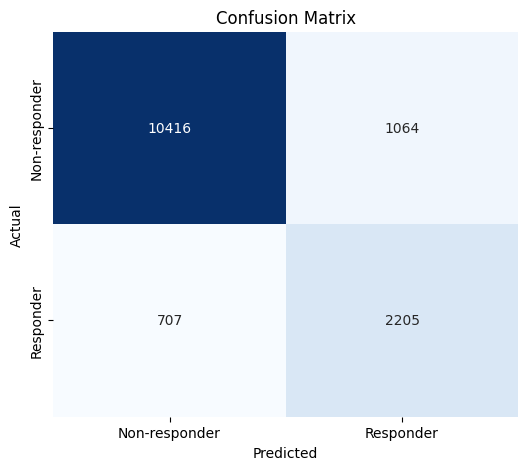

In [23]:
# Step 1: Define pipeline (scaling + logistic regression)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        solver='liblinear',
        class_weight='balanced',
        random_state=42
    ))
])

# Step 2: Smaller parameter grid for faster search
param_grid = {
    'logreg__C': [0.1, 1, 10],
    'logreg__penalty': ['l1','l2']
}

# Step 3: Run GridSearchCV
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,              # fewer folds to speed up
    scoring='roc_auc', # still optimizes AUC
    n_jobs=-1
)
grid.fit(X_train, y_train)

# Step 4: Best model
logreg = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

# Step 5: Predictions
y_prob = logreg.predict_proba(X_test)[:, 1]
y_pred_thresh = logreg.predict(X_test)

# Step 6: Evaluation metrics
conf_mat = confusion_matrix(y_test, y_pred_thresh)
roc = roc_auc_score(y_test, y_prob)
precision = precision_score(y_test, y_pred_thresh)
recall = recall_score(y_test, y_pred_thresh)
f1 = f1_score(y_test, y_pred_thresh)
accuracy = accuracy_score(y_test, y_pred_thresh)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

# Step 7: Confusion Matrix Plot
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False,
    linewidths=0,
    linecolor='white'
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

------------------------------------------------------------
Train an XGBoost classifier with scale_pos_weight to handle class imbalance.
The model is evaluated on the test set using accuracy, precision, recall, F1 score, and ROC AUC.
Finally, the confusion matrix is plotted to visualize predicted versus true responses for responders and non-responders.
____

# **XGBoost**

scale_pos_weight: 1.69
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Best Parameters: {'model__learning_rate': 0.1, 'model__n_estimators': 800}

Classification Report (Test Data):
               precision    recall  f1-score   support

Non-responder       0.91      0.95      0.93     11480
    Responder       0.74      0.63      0.68      2912

     accuracy                           0.88     14392
    macro avg       0.83      0.79      0.80     14392
 weighted avg       0.88      0.88      0.88     14392


[Responder Class Metrics]
Accuracy     : 88.07
Precision    : 74.40
Recall       : 62.57
F1 Score     : 67.97
ROC AUC Score: 92.63


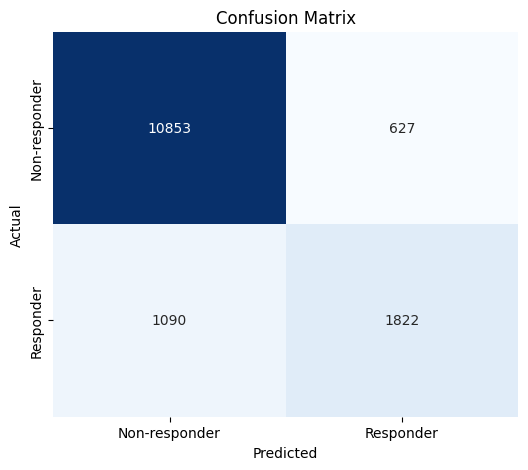

In [24]:
# Step 1: Compute class weights to address imbalance
neg = (y_train == 0).sum()  # Non-responders
pos = (y_train == 1).sum()  # Responders
scale_pos_weight = neg / pos
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

# Step 2: Define pipeline (XGBoost only, no scaler needed)
pipe_xgb = Pipeline([
    ('model', XGBClassifier(
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        tree_method='hist',
        random_state=42
    ))
])

# Step 3: Parameter grid (same as original)
param_xgb = {
    'model__learning_rate': [0.01, 0.1],
    'model__n_estimators': [200, 400, 800]
}

# Step 4: GridSearchCV with 3-fold CV
grid_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_xgb,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Step 5: Fit
grid_xgb.fit(X_train, y_train)

# Step 6: Best model
best_xgb = grid_xgb.best_estimator_
print("\nBest Parameters:", grid_xgb.best_params_)

# Step 7: Predictions
y_pred = best_xgb.predict(X_test)
y_prob = best_xgb.predict_proba(X_test)[:, 1]

# Step 8: Evaluation metrics
conf_mat = confusion_matrix(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Step 8b: Classification Report
print("\nClassification Report (Test Data):")
print(classification_report(
    y_test,
    y_pred,
    target_names=['Non-responder', 'Responder']
))

# Step 9: Print metrics
print("\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

# Step 10: Confusion Matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False,
    linewidths=0,
    linecolor='white'
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **Feature Selection**

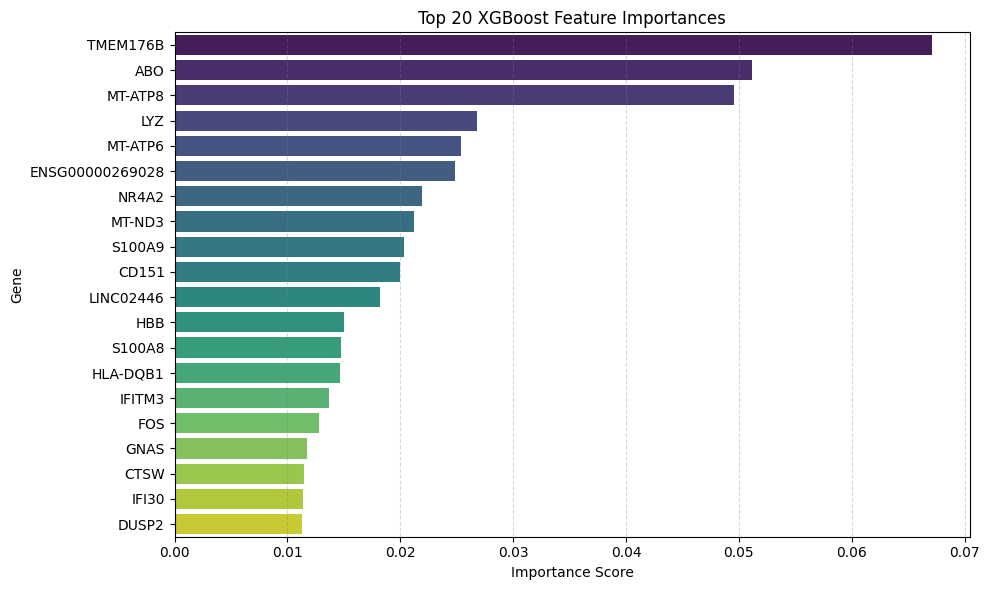

In [25]:
# Step 11: Feature Importances from best XGBoost model
importances = best_xgb.named_steps['model'].feature_importances_
feature_names = X_train.columns

# Sort features by importance
sorted_idx = importances.argsort()[::-1]
sorted_features = feature_names[sorted_idx]
sorted_importances = importances[sorted_idx]

# Select top N features (e.g., 20)
top_n = 20
top_features = sorted_features[:top_n]
top_importances = sorted_importances[:top_n]

# Plot top feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_features, palette='viridis')
plt.title(f"Top {top_n} XGBoost Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Gene")
plt.grid(True, axis='x', linestyle='--', alpha=0.3, color='gray')
plt.tight_layout()
plt.show()


# **Random Forest**

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Parameters: {'model__min_samples_leaf': 50}

[Responder Class Metrics]
Accuracy     : 90.06
Precision    : 78.85
Recall       : 69.51
F1 Score     : 73.88
ROC AUC Score: 94.83

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.94     11480
           1       0.79      0.70      0.74      2912

    accuracy                           0.90     14392
   macro avg       0.86      0.82      0.84     14392
weighted avg       0.90      0.90      0.90     14392



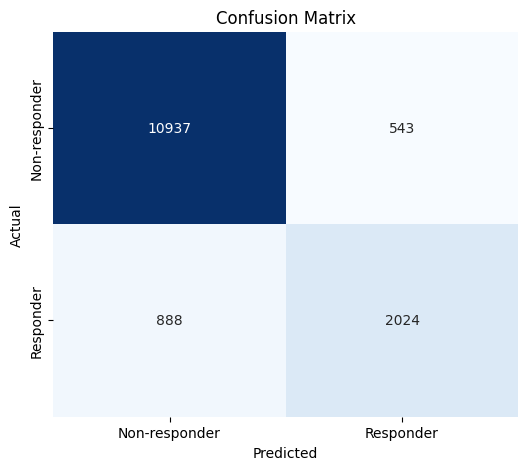

In [26]:
# Step 1: Define pipeline (RF only, no scaler needed)
pipe_rf = Pipeline([
    ('model', RandomForestClassifier(
        n_estimators=500,
        max_features='sqrt',
        max_depth=8,
        min_samples_split=100,
        class_weight='balanced',
        random_state=42
    ))
])

# Step 2: Parameter grid
param_rf = {
    'model__min_samples_leaf': [50, 100]
}

# Step 3: GridSearchCV with 3-fold CV
grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_rf,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Step 4: Fit GridSearchCV
grid_rf.fit(X_train, y_train)

# Step 5: Best model
best_rf = grid_rf.best_estimator_
print("Best Parameters:", grid_rf.best_params_)

# Step 6: Predictions
y_prob = best_rf.predict_proba(X_test)[:, 1]
y_pred = best_rf.predict(X_test)

# Step 7: Evaluation metrics
conf_mat = confusion_matrix(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Step 8: Print metrics
print("\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Step 9: Confusion Matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Non-responder", "Responder"],
    yticklabels=["Non-responder", "Responder"],
    cbar=False,
    linewidths=0,
    linecolor="white"
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# **Artificial Neural Network**

In [27]:
# ------------------------------
# Imports
# ------------------------------
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    confusion_matrix
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ------------------------------
# Reproducibility setup
# ------------------------------
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# ------------------------------
# Step 1: Scale features
# ------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------------------
# Step 2: Define ANN
# ------------------------------
ann_model = Sequential([
    Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# ------------------------------
# Step 3: Compile
# ------------------------------
ann_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ------------------------------
# Step 4: Compute class weights
# ------------------------------
classes = np.unique(y_train)
class_weights_values = compute_class_weight(
    class_weight='balanced', classes=classes, y=y_train
)
class_weight_dict = dict(zip(classes, class_weights_values))
print(f"Using class weights: {class_weight_dict}")

# ------------------------------
# Step 5: Early stopping
# ------------------------------
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# ------------------------------
# Step 6: Train
# ------------------------------
history = ann_model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    shuffle=True,
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1
)

Using class weights: {np.int64(0): np.float64(0.7962067209775967), np.int64(1): np.float64(1.3440051568543188)}
Epoch 1/50
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6331 - loss: 0.6888 - val_accuracy: 0.8588 - val_loss: 0.3642
Epoch 2/50
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7578 - loss: 0.4810 - val_accuracy: 0.8510 - val_loss: 0.3433
Epoch 3/50
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7773 - loss: 0.4509 - val_accuracy: 0.8515 - val_loss: 0.3378
Epoch 4/50
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7842 - loss: 0.4399 - val_accuracy: 0.8542 - val_loss: 0.3354
Epoch 5/50
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7891 - loss: 0.4294 - val_accuracy: 0.8498 - val_loss: 0.3369
Epoch 6/50
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7951 - loss: 0.4220 - val_accuracy: 0.8545 - val_loss: 0.3296
Epoch 7/50
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7949 - loss: 0.4182 - val_accuracy: 0.8

1369/1369 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

[Responder Class Metrics]
Accuracy     : 85.45
Precision    : 60.68
Recall       : 79.81
F1 Score     : 68.94
ROC AUC Score: 91.35

Classification Report (Test Data):
               precision    recall  f1-score   support

Non-responder       0.94      0.87      0.90     11480
    Responder       0.61      0.80      0.69      2912

     accuracy                           0.85     14392
    macro avg       0.78      0.83      0.80     14392
 weighted avg       0.88      0.85      0.86     14392



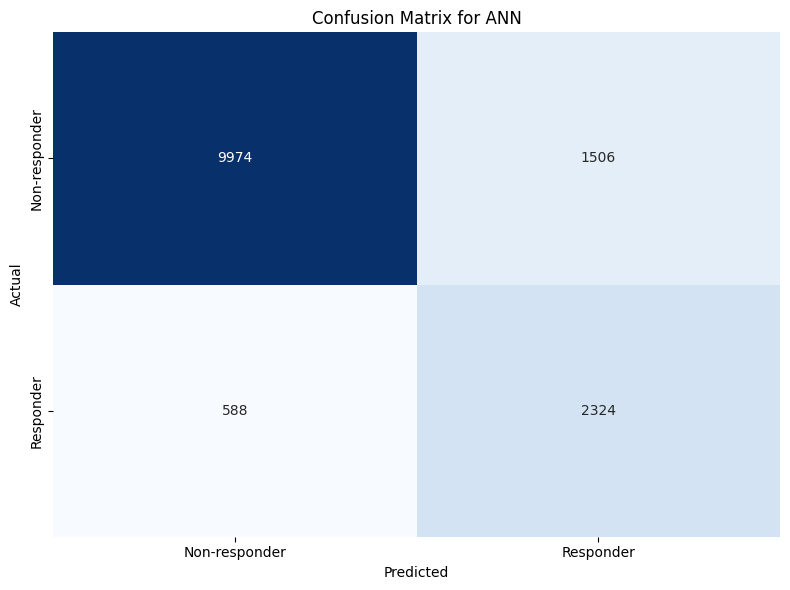

In [28]:
# 5. Predictions
y_train_pred_prob = ann_model.predict(X_train_scaled).flatten()
y_test_pred_prob = ann_model.predict(X_test_scaled).flatten()

# Use default 0.5 threshold for binary classification
y_train_pred_classes = (y_train_pred_prob > 0.5).astype(int)
y_test_pred_classes = (y_test_pred_prob > 0.5).astype(int)

# 6. Calculate metrics for Responder class (label=1)
train_acc = accuracy_score(y_train, y_train_pred_classes)
test_acc = accuracy_score(y_test, y_test_pred_classes)
precision = precision_score(y_test, y_test_pred_classes, pos_label=1)
recall = recall_score(y_test, y_test_pred_classes, pos_label=1)
f1 = f1_score(y_test, y_test_pred_classes, pos_label=1)
roc_auc = roc_auc_score(y_test, y_test_pred_prob)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {test_acc*100:.2f}")
print(f"Precision    : {precision*100:.2f}")
print(f"Recall       : {recall*100:.2f}")
print(f"F1 Score     : {f1*100:.2f}")
print(f"ROC AUC Score: {roc_auc*100:.2f}\n")

print("Classification Report (Test Data):")
print(classification_report(y_test, y_test_pred_classes, target_names=['Non-responder', 'Responder']))

# 7. Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False,
    linewidths=0,
    linecolor='white'
)
plt.title("Confusion Matrix for ANN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


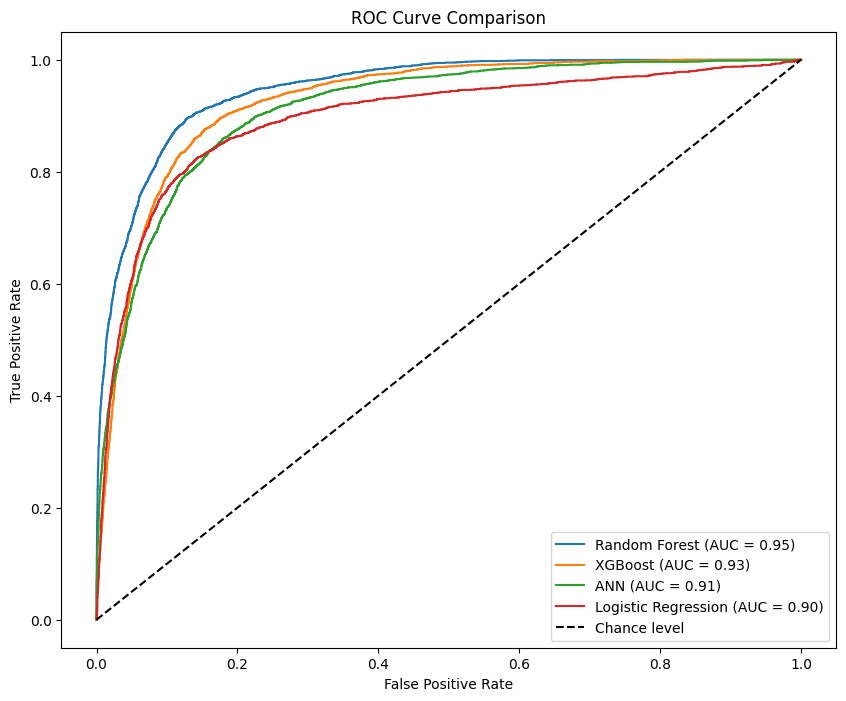

In [29]:
# --- Get prediction probabilities from each model ---
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]          # Random Forest (best model from GridSearchCV)
y_prob_xgb = best_xgb.predict_proba(X_test)[:, 1]        # XGBoost (best model from GridSearchCV)
y_prob_ann = ann_model.predict(X_test_scaled).ravel()    # ANN uses scaled test set
y_prob_lr = logreg.predict_proba(X_test)[:, 1]           # Logistic Regression pipeline

# --- Compute ROC curve and AUC for each model ---
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_ann, tpr_ann, _ = roc_curve(y_test, y_prob_ann)
auc_ann = auc(fpr_ann, tpr_ann)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
auc_lr = auc(fpr_lr, tpr_lr)

# --- Plot ROC curves together ---
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot(fpr_ann, tpr_ann, label=f'ANN (AUC = {auc_ann:.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance level')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(False)
plt.show()

# **Calibration plots**

450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


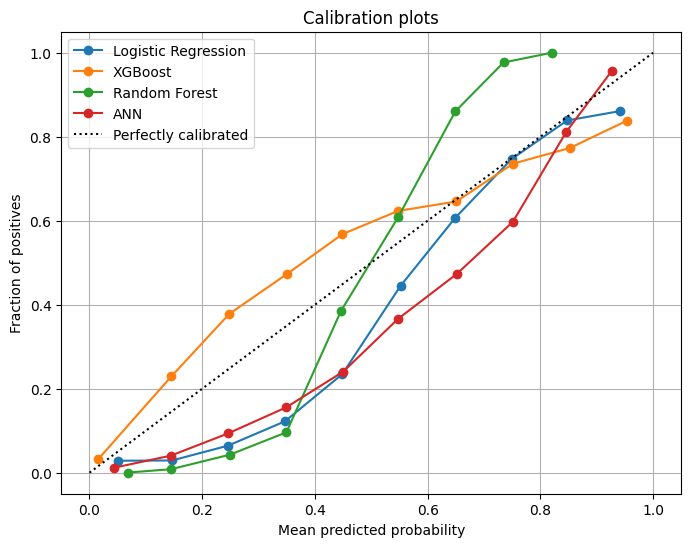

In [30]:
# --- Get prediction probabilities from trained models ---
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]           # Random Forest (best model from GridSearchCV)
y_prob_xgb = best_xgb.predict_proba(X_test)[:, 1]         # XGBoost (best model from GridSearchCV)
y_prob_ann = ann_model.predict(X_test_scaled).ravel()     # ANN uses scaled test set
y_prob_lr = logreg.predict_proba(X_test)[:, 1]            # Logistic Regression pipeline

# --- Plot calibration curves ---
plt.figure(figsize=(8, 6))

for model_name, y_prob in [
    ('Logistic Regression', y_prob_lr),
    ('XGBoost', y_prob_xgb),
    ('Random Forest', y_prob_rf),
    ('ANN', y_prob_ann)
]:
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=model_name)

plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration plots')
plt.legend()
plt.grid(True)
plt.show()

# **Brier scores**

In [31]:
# --- Compute Brier scores for each model ---
brier_lr = brier_score_loss(y_test, y_prob_lr)          # Logistic Regression
brier_xgb = brier_score_loss(y_test, y_prob_xgb)        # XGBoost
brier_rf = brier_score_loss(y_test, y_prob_rf)          # Random Forest
brier_ann = brier_score_loss(y_test, y_prob_ann)        # ANN

# --- Print Brier scores ---
print(f"Brier Score - Logistic Regression: {brier_lr:.4f}")
print(f"Brier Score - XGBoost: {brier_xgb:.4f}")
print(f"Brier Score - Random Forest: {brier_rf:.4f}")
print(f"Brier Score - ANN: {brier_ann:.4f}")

Brier Score - Logistic Regression: 0.1034
Brier Score - XGBoost: 0.0865
Brier Score - Random Forest: 0.0956
Brier Score - ANN: 0.1024


# **MCC**

In [32]:
threshold = 0.5  # You can adjust if needed

# --- Predicted classes for each model using the threshold ---
y_pred_lr = (y_prob_lr > threshold).astype(int)
y_pred_xgb = (y_prob_xgb > threshold).astype(int)
y_pred_rf = (y_prob_rf > threshold).astype(int)
y_pred_ann = y_test_pred_classes  # Already computed with default 0.5 threshold

# --- Compute Matthews Correlation Coefficient ---
mcc_lr = matthews_corrcoef(y_test, y_pred_lr)
mcc_xgb = matthews_corrcoef(y_test, y_pred_xgb)
mcc_rf = matthews_corrcoef(y_test, y_pred_rf)
mcc_ann = matthews_corrcoef(y_test, y_pred_ann)

# --- Print MCC for all models ---
print(f"MCC - Logistic Regression: {mcc_lr:.4f}")
print(f"MCC - XGBoost: {mcc_xgb:.4f}")
print(f"MCC - Random Forest: {mcc_rf:.4f}")
print(f"MCC - ANN: {mcc_ann:.4f}")

MCC - Logistic Regression: 0.6372
MCC - XGBoost: 0.6105
MCC - Random Forest: 0.6798
MCC - ANN: 0.6062


# **SHAP**

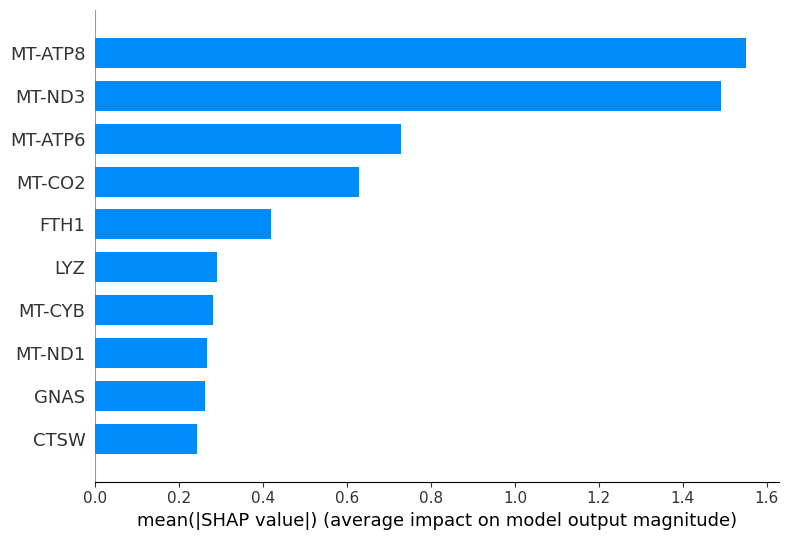

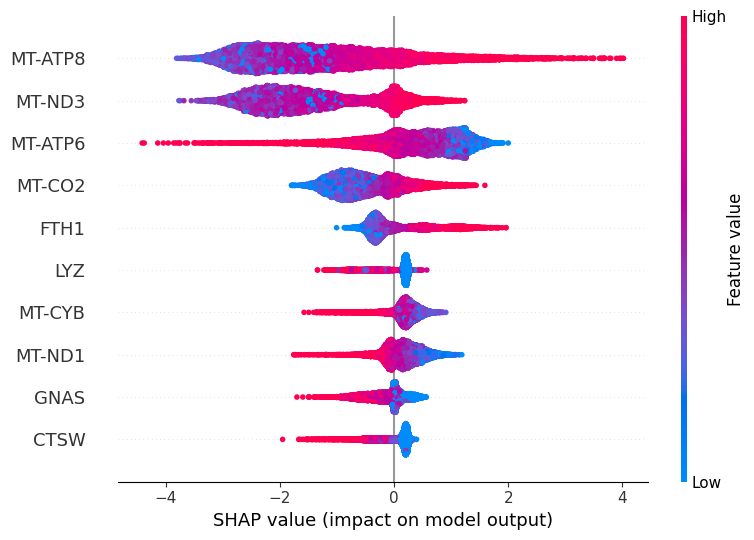

In [33]:
# Plotting only 10 features

# Step 1: Get the feature names
feature_names = X_train.columns

# Step 2: Extract the fitted XGB model from the pipeline
fitted_xgb = best_xgb.named_steps['model']

# Step 3: Create SHAP explainer
explainer = shap.TreeExplainer(fitted_xgb)

# Step 4: Compute SHAP values for test set
shap_values = explainer.shap_values(X_test)

# Step 5: Compute mean absolute SHAP values across samples
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# Step 6: Get indices of top 10 features
top_idx = np.argsort(mean_abs_shap)[-10:]

# Step 7: Restrict to top 10 features
X_test_top = X_test.iloc[:, top_idx]
shap_values_top = shap_values[:, top_idx]
feature_names_top = X_test_top.columns

# Step 8: Plot summary (bar + beeswarm) for top 10 features
shap.summary_plot(shap_values_top, X_test_top, feature_names=feature_names_top, plot_type="bar")
shap.summary_plot(shap_values_top, X_test_top, feature_names=feature_names_top)